In [1]:
import pandas as pd
import torch
import torch.nn as nn
from torch.optim import SGD
from torch.utils.data import DataLoader, random_split, Dataset

#### What new? (Personal reference)
- usage of np.bincount()
- custom Dataset generation with feature-label mapping
- usage of Glorot initialisation
- usage of torch.where
- While normalisation, we have to use params of train set to valid and test set ?
    - We have to use params of train set

## Data loading

In [2]:
data = pd.read_csv("data_banknote_authentication.txt",names=['variance', 'skewness', 'curtosis','entropy of image', 'class'])
data.head()

,variance,skewness,curtosis,entropy of image,class
0,3.62160,8.6661,-2.8073,-0.44699,0
1,4.54590,8.1674,-2.4586,-1.46210,0
2,3.86600,-2.6383,1.9242,0.10645,0
3,3.45660,9.5228,-4.0112,-3.59440,0
4,0.32924,-4.4552,4.5718,-0.98880,0


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1372 entries, 0 to 1371
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   variance          1372 non-null   float64
 1   skewness          1372 non-null   float64
 2   curtosis          1372 non-null   float64
 3   entropy of image  1372 non-null   float64
 4   class             1372 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 53.7 KB


#### Equally distributed - no imbalance
- If imbalance is present
    - Select different threshold on basis of precision and recall
    - Upsample/downsample using imbalance-learn library

In [4]:
import numpy as np
np.bincount(data['class']) 

array([762, 610])

## Defining Dataset

In [5]:
class MyData(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    def __getitem__(self, index):
        x = self.X[index]
        y = self.y[index]
        return x,y
    def __len__(self):
        return len(self.X)

## Splitting

In [6]:
X = data.iloc[:, :-1].values
y = data[['class']].values

In [7]:
X.shape, y.shape

((1372, 4), (1372, 1))

In [8]:
dataset = MyData(X,y)

In [9]:
torch.manual_seed(1)
train_size = int(len(dataset) * 0.8)
validation_size = len(dataset) - train_size
train, validation = random_split(dataset, [train_size, validation_size])

## Standardisation

In [10]:
train[0]

(array([ 3.4092 ,  5.4049 , -2.5228 , -0.89958]), array([0]))

## DataLoader initializing

In [11]:
batch_size = 32
train_loader = DataLoader(train, batch_size, shuffle=True)
valid_loader = DataLoader(validation, batch_size)

## Preprocessing
- Obtain mean, std of train data for each feature. Use the same parameters to standardise validation data

In [12]:
train_mean = torch.zeros(X.shape[1])
train_std = torch.zeros(X.shape[1])
for x_batch , _ in train_loader:
    train_mean += torch.sum(x_batch, axis=0)
train_mean = train_mean/len(train_loader.dataset)

for x_batch, _ in train_loader:
    train_std += torch.sum((x_batch - train_mean)**2, axis=0)
train_std = torch.sqrt(train_std/(len(train_loader.dataset)-1)) #  n-1 is used for sample parameter calculation, or else nan coming

In [13]:
train_mean,train_std

(tensor([ 0.3854,  1.8680,  1.4923, -1.1999]),
 tensor([2.8575, 5.9216, 4.3869, 2.1041]))

## Standardisation

In [14]:
def standardise(data, mean, std):
    #print(((data - mean)/std).shape)
    return (data - mean)/std

## Model

In [15]:
class Model(nn.Module):
    def __init__(self, n):
        super().__init__()
        self.w =  nn.Parameter(torch.zeros(n,1)) ## Cant have xavier transform for 1D
        nn.init.xavier_uniform_(self.w)
        self.b = nn.Parameter(torch.rand(1))
        #self.linear = nn.Linear(n,1)
    def forward(self, X):
        X = X @ self.w + self.b 
        X = torch.sigmoid(X)
        return X

In [16]:
torch.manual_seed(1)
model = Model(4)

In [17]:
loss_fn = nn.BCELoss()
optimizer = SGD(model.parameters(), lr=0.4)

In [18]:
epoch = 20
train_loss = [0] * epoch
train_accuracy = [0] * epoch

validation_loss = [0] * epoch
validation_accuracy = [0] * epoch
for i in range(epoch):
    for x_batch, y_batch in train_loader:
        x_batch = x_batch.to(torch.float32)
        y_batch = y_batch.to(torch.float32)
        pred = model(standardise(x_batch, train_mean, train_std)) # Unusually here, higher accuracy is gained quickly when it is not standardised
        #pred = model(x_batch)
        loss = loss_fn(pred, y_batch)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        train_loss[i] += loss.item() * x_batch.size(0)
        is_crt = (torch.where(pred>=0.5, 1,0) == y_batch).float().sum()
        train_accuracy[i] += is_crt
        
    with torch.no_grad():
        for x_batch, y_batch in valid_loader:
            x_batch = x_batch.to(torch.float32)
            y_batch = y_batch.to(torch.float32)
            pred = model(standardise(x_batch, train_mean, train_std))
            #pred = model(x_batch)
            loss = loss_fn(pred, y_batch)
            validation_loss[i] += loss.item() * x_batch.size(0)
            is_crt = (torch.where(pred >= 0.5, 1,0)==y_batch).float().sum()
            validation_accuracy[i] += is_crt
    train_loss[i] /= len(train_loader.dataset)
    train_accuracy[i] /= len(train_loader.dataset)
    
    validation_loss[i] /= len(valid_loader.dataset)
    validation_accuracy[i] /= len(valid_loader.dataset)
    
    print(f"Epoch: {i+1}, loss: {train_loss[i]}, Accuracy: {train_accuracy[i]}")

Epoch: 1, loss: 0.38482449010163955, Accuracy: 0.8532360792160034
Epoch: 2, loss: 0.18887637374937916, Accuracy: 0.9608021974563599
Epoch: 3, loss: 0.1433228964602393, Accuracy: 0.9680948257446289
Epoch: 4, loss: 0.11925510133029986, Accuracy: 0.9717411398887634
Epoch: 5, loss: 0.10450479379407689, Accuracy: 0.9726526737213135
Epoch: 6, loss: 0.094118468735092, Accuracy: 0.9744758605957031
Epoch: 7, loss: 0.08682195998307185, Accuracy: 0.976298987865448
Epoch: 8, loss: 0.0809650673525053, Accuracy: 0.9772105813026428
Epoch: 9, loss: 0.07643201808320357, Accuracy: 0.9781221747398376
Epoch: 10, loss: 0.07270602289665365, Accuracy: 0.9781221747398376
Epoch: 11, loss: 0.06960979984256498, Accuracy: 0.9799453020095825
Epoch: 12, loss: 0.06689947895169149, Accuracy: 0.9799453020095825
Epoch: 13, loss: 0.0645481215699923, Accuracy: 0.9799453020095825
Epoch: 14, loss: 0.06259475500342404, Accuracy: 0.9799453020095825
Epoch: 15, loss: 0.06080795110032682, Accuracy: 0.9799453020095825
Epoch: 16,


## Visualisation

In [19]:
import matplotlib.pyplot as plt

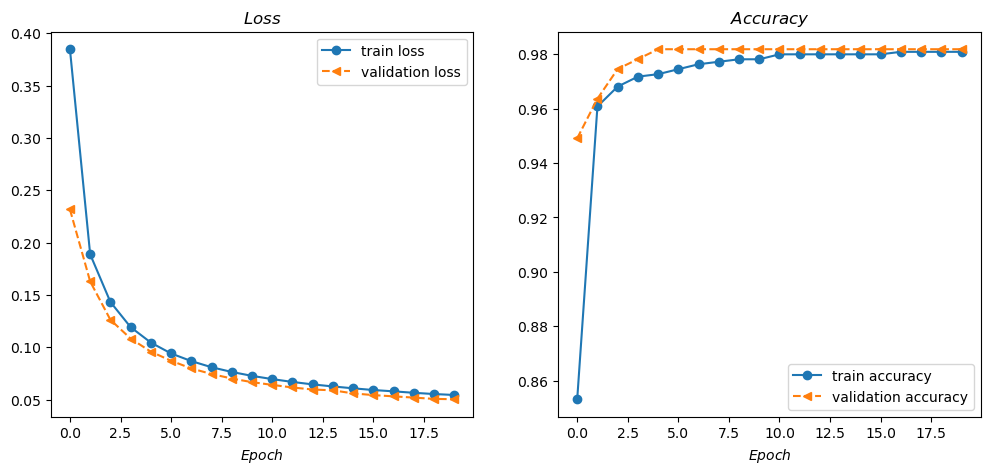

In [20]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(np.arange(epoch), train_loss, '-o')
plt.plot(np.arange(epoch), validation_loss, '--<')
plt.xlabel("$Epoch$")
plt.title("$Loss$")
plt.legend(['train loss', 'validation loss'])

plt.subplot(1,2,2)
plt.plot(np.arange(epoch), train_accuracy, '-o')
plt.plot(np.arange(epoch), validation_accuracy, '--<')
plt.xlabel("$Epoch$")
plt.title("$Accuracy$")
plt.legend(['train accuracy', 'validation accuracy'])

## Observation
- Unusually when I didn't standardise the value, higher accuracy is achieved quickly
- But that accuracy/loss graph was not stable. But when I had standardised the values, I have got a steady graph as above